PART II

k-Nearest Neighbours

Generating the data (Q6)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist

In [11]:
v = 3
n_centers = 100
np.random.seed(11)

In [12]:
def sample_S(n_centers):
    centers = np.random.uniform(0, 1, size=(n_centers, 2))
    labels = np.random.randint(0, 2, size=n_centers)
    return centers, labels

def voted_center_hypothesis(x_test, centers, labels, v):
    # Calculate the distance from x_test to all centers
    distances = cdist(x_test.reshape(1, 2), centers)[0]

    # Get the indices of the v nearest neighbors
    # argsort returns the indices that would sort the array
    nearest_indices = np.argsort(distances)[:v]

    # Look up the labels and count the votes
    nearest_labels = labels[nearest_indices]
    votes_0 = np.sum(nearest_labels == 0)
    votes_1 = np.sum(nearest_labels == 1)

    # Determine the classification
    if votes_0 > votes_1:
        return 0  # White area
    elif votes_1 > votes_0:
        return 1  # Turquoise area
    else:
        # Tie case, only possible for even 'v'
        return np.random.randint(0,2) # generate label randomly


In [13]:
# Define the resolution of the decision boundary plot
resolution = 200

# Create a mesh grid over [0, 1]x[0, 1]
xx, yy = np.meshgrid(np.linspace(0, 1, resolution),
                     np.linspace(0, 1, resolution))

# Flatten the grid points into a list of (x, y) coordinates
grid_points = np.array(list(zip(xx.flatten(), yy.flatten())))

print(f"Calculating classification for {len(grid_points)} grid points...")


# Sample S
centers, labels = sample_S(n_centers)

# Apply the hypothesis function to every point on the grid
Z_flat = np.array([voted_center_hypothesis(p, centers, labels, v) 
                   for p in grid_points])

# Reshape the results back into the grid shape for plotting
Z = Z_flat.reshape(xx.shape)

print("Classification complete.")




Calculating classification for 40000 grid points...
Classification complete.


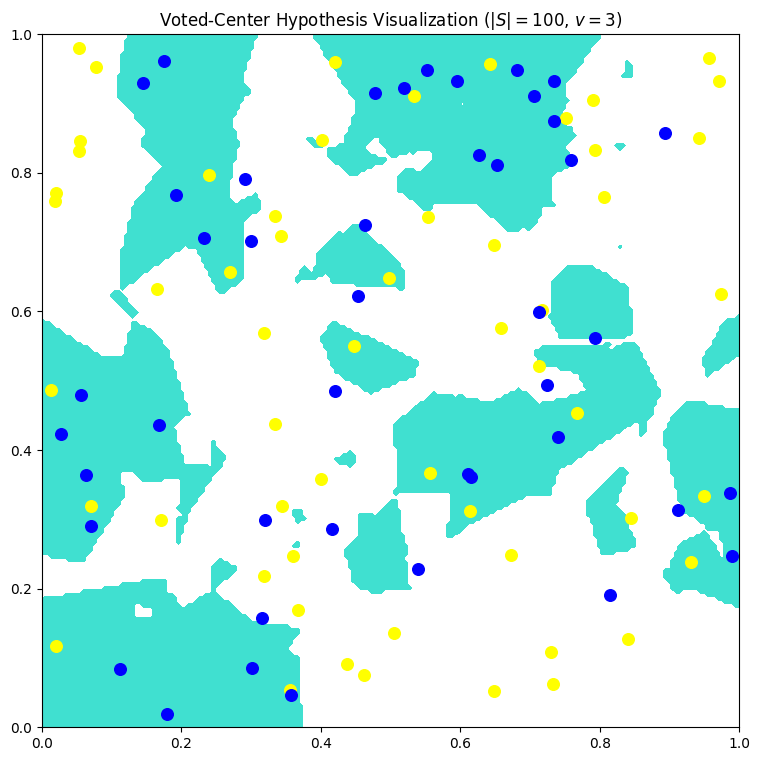

In [14]:
plt.figure(figsize=(9, 9))

# Define custom colormap: White (0) and Turquoise (1) - Tie Break is Grey (-1)
cmap_list = ['#FFFFFF', '#40E0D0']  # Grey (-1), White (0), Turquoise (1)
cmap = ListedColormap(cmap_list)

# Define boundaries for the contour plot
levels = [-0.5, 0.5, 1.5] 

# Plot the decision boundary (the function h_S,v(x))
plt.contourf(xx, yy, Z, levels=levels, cmap=cmap)

# Plot the centers S
centers_0 = centers[labels == 0]
centers_1 = centers[labels == 1]

plt.scatter(centers_0[:, 0], centers_0[:, 1], 
            marker='o', s=70, color='yellow', linewidth=1)
plt.scatter(centers_1[:, 0], centers_1[:, 1], 
            marker='o', s=70, color='blue', linewidth=1)

plt.title(f'Voted-Center Hypothesis Visualization ($|S|={n_centers}$, $v={v}$)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


Estimated generalisation error of k-NN as a function of k (Q7)

In [15]:
from tqdm import tqdm
from collections import Counter

In [16]:
class kNNClassifier:
    def __init__(self, k):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.k = k
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test):
        distances = cdist(X_test, self.X_train, metric='euclidean')
        knn_indices = np.argsort(distances, axis=1)[:, :self.k]
        knn_labels = self.y_train[knn_indices]
        vote_winners = np.empty(X_test.shape[0], dtype=self.y_train.dtype)
        for i in range(knn_labels.shape[0]):
            most_common = Counter(knn_labels[i]).most_common(1)
            vote_winners[i] = most_common[0][0]
        return vote_winners


    def score(self, X_test, y_test):
        predictions = self.predict(X_test)
        correct_predictions = np.sum(predictions == y_test)
        accuracy = correct_predictions / len(y_test)
        return accuracy

In [17]:
def sample_noisy_S(n_centers, true_centers, true_labels, true_v):

    centers = np.random.uniform(0, 1, size=(n_centers, 2))
    labels = np.array([voted_center_hypothesis(c, true_centers, true_labels, true_v) for c in centers])

    cf_mask = np.random.rand(n_centers) < 0.2

    for cf_idx, cf in enumerate(cf_mask):
        if cf: labels[cf_idx] = np.random.randint(2)
    return centers, labels

def run_kNN_test(k, X_train, Y_train, X_test, Y_test):
    model = kNNClassifier(k)
    model.fit(X_train, Y_train)
    accuracy = model.score(X_test, Y_test)
    error = 1.0 - accuracy
    return error

In [18]:
true_centers, true_labels = sample_S(100)
true_v = 3
k_list = np.arange(1, 50, 1)
n_train = 4000
n_test = 1000
n_runs = 100

errors = np.zeros((n_runs, len(k_list)))

for iter in tqdm(range(n_runs)):
    train_centers, train_labels = sample_noisy_S(n_train, true_centers, true_labels, true_v)
    test_centers, test_labels = sample_noisy_S(n_test, true_centers, true_labels, true_v)
    for idx, k in enumerate(k_list):
        error = run_kNN_test(k, train_centers, train_labels, test_centers, test_labels)
        errors[iter, idx] = error

mean_errors = np.mean(errors, axis=0)

  2%|▏         | 2/100 [00:23<19:15, 11.79s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(k_list, mean_errors, marker='o', linestyle='-', color='blue')

plt.title('Mean Error of k-NN as a Function of k')
plt.xlabel('Number of Nearest Neighbors, k')
plt.ylabel('Mean Error')
plt.grid(True, linestyle='--', alpha=0.6)


# Highlight the minimum error
min_error = np.min(mean_errors)
optimal_k = k_list[np.argmin(mean_errors)]
plt.scatter(optimal_k, min_error, color='red', s=100, label=f'Min Error at k={optimal_k:.0f}')
plt.legend()
plt.show()

The curve's U-shape is a depiction of the Bias-Variance Trade-off in k-NN.  The noisiness of the U-shape is due to the random selection of classification labels in tie cases for kNN with even k.  Generally, for fixed m, increasing k both reduces variance and increases bias.  By increasing k, more samples are used for prediction and so any noise on any single sample has less impact on the overall predictive performance, thereby reducing variance.  However, by using more samples for prediction (with a fixed m), a larger more generalised neighbourhood is used for prediction, which can smooth out local structure and mask the complexity of the true underlying function, which is an increase in bias.  The optimal error of this tradeoff is found at k=9.  Here, the curve shows a minimum at just over 0.15, where an optimal algorithm could reach an error of 0.1 as in expectation given 20% of the samples are randomly sampled from {0,1}, we would expect half of those to still be correctly labelled by chance - leaving 10% minimum error.

Determine the optimal k as a function of the number of training points (m) (Q8)

In [ ]:
m_list = np.arange(500,4500,500)
m_list = np.insert(m_list, 0, 100)
optimal_k_list = np.zeros(len(m_list))

for mIdx, m in enumerate(m_list):
    print('m = ', m)
    true_centers, true_labels = sample_S(100)
    true_v = 3
    k_list = np.arange(1, 50, 2)
    n_train = m
    n_test = 1000
    n_runs = 100

    errors = np.zeros((n_runs, len(k_list)))

    for iter in tqdm(range(n_runs)):
        train_centers, train_labels = sample_noisy_S(n_train, true_centers, true_labels, true_v)
        test_centers, test_labels = sample_noisy_S(n_test, true_centers, true_labels, true_v)
        for kIdx, k in enumerate(k_list):
            error = run_kNN_test(k, train_centers, train_labels, test_centers, test_labels)
            errors[iter, kIdx] = error

    mean_errors = np.mean(errors, axis=0)
    optimal_k = k_list[np.argmin(mean_errors)]
    optimal_k_list[mIdx] = optimal_k
    print('Optimal k = ', optimal_k)


In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(m_list, optimal_k_list, marker='o', linestyle='-', color='blue')

plt.title('Optimal k as a Function of m')
plt.xlabel('Number of Training Points, m')
plt.ylabel('Optimal k')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The curve shows a monotonically increasing shape - as m (the number of training points) increases, so does the optimal k.  This is because increasing m means increasing the number of samples in the local neighbourhood for prediction, and so more samples can be used without taking samples from further away from the inference point, which would overly smoothing out local structure.  In other words, increasing m allows a larger increase in k before bias dominates the bias-variance tradeoff.